In [1]:
#imports
import pandas as pd
from pathlib import Path
import requests
import json
from configuration import APIkeys
import re
from pandas import json_normalize 
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np
from sklearn import datasets



In [2]:
#Create a dataframe from park opening history


file = Path("../Resources/Park_Opening_Dates.csv")

opening_dates_df = pd.read_csv(file)

national_parks_opening_dates_df = opening_dates_df[opening_dates_df['Park Name and Location'].str.contains("National Park")]

clean_national_parks_opening_dates = national_parks_opening_dates_df[~national_parks_opening_dates_df["Park Name and Location"].str.contains('transferred')].drop('Date', axis=1)

clean_national_parks_opening_dates['Park Name'] = clean_national_parks_opening_dates['Park Name and Location'].str.split(',').str[0]

clean_national_parks_opening_dates_final = clean_national_parks_opening_dates.drop(['Park Name and Location'], axis=1)

parks_openings = clean_national_parks_opening_dates_final.replace(' National Park', "", regex=True)

parks_openings.reset_index(drop=True, inplace=True)

parks_openings


,Year,Park Name
0,1832,Hot Springs
1,1872,Yellowstone
2,1890,Sequoia
3,1890,Kings Canyon
4,1890,Yosemite
...,...,...
61,1978,Kobuk Valley
62,1978,Lake Clark and Lake Clark National Preserve
63,1978,Wrangell-St. Elias and Wrangell-St. Elias Nati...
64,1988,National Park of American Samoa


In [3]:
#Create a Dataframe from national parks API Data

parks_api_key = APIkeys.parks_api_key

#Establish nps endpoint - with api key
endpoint = f"https://developer.nps.gov/api/v1/parks?limit=600&api_key={parks_api_key}"

#turn the result into a json file
parks_data = requests.get(endpoint).json()

#Normalize data so it all fits into a dataframe
normalized_parks_data = json_normalize(parks_data, 'data')

#Drop the columns we dont need
all_parks_df = pd.DataFrame(normalized_parks_data).drop(columns=[
'id', 
    'url', 
    'latLong', 
    'directionsInfo', 
    'directionsUrl', 
    'addresses', 
    'images', 
    'contacts.phoneNumbers',
    'contacts.emailAddresses',
    
])

#sort by only those named national park or national park and preserve
national_parks_df = all_parks_df.loc[(all_parks_df['designation'] == "National Park") | (all_parks_df['designation'] == "National Park & Preserve")]
national_parks_df.replace(' NP','', regex=True)

#create a copy to start renaming columns
national_parks_df_clean = national_parks_df.copy()

#rename columns
national_parks_df_clean.rename(columns={
    'fullName':'Full Name',
    'parkCode':'Park Code',
    'description':'Description',
    'latitude':'Latitude',
    'longitude':'Longitude',
    'activities':'Activities',
    'topics':'Topics',
    'states':'States',
    'entranceFees':'Entrance Fees',
    'entrancePasses':'Entrance Passes',
    'fees':'Fees',
    'operatingHours':'Operating Hours',
    'weatherInfo':'Weather Info',
    'designation':'Designation',
    'name':'Park Name'
}, inplace = True)

national_parks_df_clean.reset_index(drop=True, inplace=True)



national_parks_df_clean.head()



,Full Name,Park Code,Description,Latitude,Longitude,Activities,Topics,States,Entrance Fees,Entrance Passes,Fees,Operating Hours,Weather Info,Park Name,Designation
0,Acadia National Park,acad,Acadia National Park protects the natural beau...,44.409286,-68.247501,[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '00F3C3F9-2D67-4802-81AE-CCEA5D3BA370'...,ME,"[{'cost': '6.00', 'description': 'Vehicle rese...","[{'cost': '70.00', 'description': 'The Acadia ...",[],"[{'exceptions': [], 'description': 'Acadia Nat...","Located on Mount Desert Island in Maine, Acadi...",Acadia,National Park
1,Arches National Park,arch,"Discover a landscape of contrasting colors, la...",38.72261844,-109.5863666,[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,UT,"[{'cost': '2.00', 'description': 'From April 1...","[{'cost': '55.00', 'description': 'Valid for o...",[],"[{'exceptions': [], 'description': 'Arches Nat...","Arches is part of the Colorado Plateau, a ""hig...",Arches,National Park
2,Badlands National Park,badl,The rugged beauty of the Badlands draws visito...,43.68584846,-102.482942,[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,SD,"[{'cost': '30.00', 'description': 'Fee covers ...","[{'cost': '55.00', 'description': 'This pass a...",[],"[{'exceptions': [], 'description': 'The park i...",The Badlands weather is variable and unpredict...,Badlands,National Park
3,Big Bend National Park,bibe,There is a place in Far West Texas where night...,29.29817767,-103.2297897,[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,TX,"[{'cost': '30.00', 'description': 'Admits one ...","[{'cost': '55.00', 'description': 'Big Bend Na...",[],"[{'exceptions': [], 'description': 'Big Bend N...","Big Bend is a desert park, so be prepared for ...",Big Bend,National Park
4,Biscayne National Park,bisc,"Within sight of Miami, yet worlds away, Biscay...",25.490587,-80.21023851,[{'id': '071BA73C-1D3C-46D4-A53C-00D5602F7F0E'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,FL,[],[],[],"[{'exceptions': [], 'description': 'Park water...","The park is situated in a subtropical climate,...",Biscayne,National Park


In [4]:
#Create a dataframe with the visitors data stored in the csv

park_visitors_csv_file = Path("../Resources/national_park_visitors.csv")

#Read the csv and create variable called park_visitors_data
park_visitors_data= pd.read_csv(park_visitors_csv_file)

#Clean up the " NP" Part of the Park Name
park_visitors_df_clean = park_visitors_data.replace(' NP','', regex=True)

#Make it into a dataframe
park_visitors_df = pd.DataFrame(park_visitors_df_clean)

park_visitors_df.rename(columns={"ParkName": "Park Name"}, inplace=True)

park_visitors_df.reset_index(drop=True, inplace=True)

park_visitors_df

,Park Name,Rank,Value,PercentOfTotal
0,Great Smoky Mountains,1,"12,937,633",14.59%
1,Grand Canyon,2,"4,732,101",5.34%
2,Zion,3,"4,692,417",5.29%
3,Rocky Mountain,4,"4,300,424",4.85%
4,Acadia,5,"3,970,260",4.48%
...,...,...,...,...
58,Isle Royale,59,"25,454",0.03%
59,Lake Clark & PRES,60,"18,187",0.02%
60,Kobuk Valley,61,"16,925",0.02%
61,Gates of the Arctic & PRES,62,"9,457",0.01%


In [5]:
#merge visitor df and park df
combined_park_data_df = park_visitors_df.merge(national_parks_df_clean, on="Park Name", how='left')

combined_park_data_df.dropna(how='any', inplace=True)

print(len(combined_park_data_df))
combined_park_data_df.reset_index(drop=True, inplace=True)
combined_park_data_df

48


,Park Name,Rank,Value,PercentOfTotal,Full Name,Park Code,Description,Latitude,Longitude,Activities,Topics,States,Entrance Fees,Entrance Passes,Fees,Operating Hours,Weather Info,Designation
0,Great Smoky Mountains,1,"12,937,633",14.59%,Great Smoky Mountains National Park,grsm,Ridge upon ridge of forest straddles the borde...,35.60116374,-83.50818326,[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[],"NC,TN",[],[],[],"[{'exceptions': [], 'description': 'Primary ro...",Elevations in the park range from approximatel...,National Park
1,Grand Canyon,2,"4,732,101",5.34%,Grand Canyon National Park,grca,"Grand Canyon National Park, in Northern Arizon...",36.0001165336,-112.121516363,[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,AZ,"[{'cost': '35.00', 'description': 'Admits one ...","[{'cost': '70.00', 'description': 'Available t...",[],"[{'exceptions': [], 'description': 'Both Deser...",This weather varies with cold winters and mild...,National Park
2,Zion,3,"4,692,417",5.29%,Zion National Park,zion,Follow the paths where native people and pione...,37.29839254,-113.0265138,[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,UT,"[{'cost': '6.00', 'description': 'Rangers may ...",[],[],"[{'exceptions': [], 'description': 'Zion Natio...",Zion is known for a wide range of weather cond...,National Park
3,Rocky Mountain,4,"4,300,424",4.85%,Rocky Mountain National Park,romo,Rocky Mountain National Park's 415 square mile...,40.3556924,-105.6972879,[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,CO,"[{'cost': '30.00', 'description': '1-Day Vehic...","[{'cost': '70.00', 'description': 'RMNP Park-s...",[],"[{'exceptions': [], 'description': 'While cert...","Weather can change quickly in RMNP, due to Roc...",National Park
4,Acadia,5,"3,970,260",4.48%,Acadia National Park,acad,Acadia National Park protects the natural beau...,44.409286,-68.247501,[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '00F3C3F9-2D67-4802-81AE-CCEA5D3BA370'...,ME,"[{'cost': '6.00', 'description': 'Vehicle rese...","[{'cost': '70.00', 'description': 'The Acadia ...",[],"[{'exceptions': [], 'description': 'Acadia Nat...","Located on Mount Desert Island in Maine, Acadi...",National Park
5,Yosemite,6,"3,667,550",4.14%,Yosemite National Park,yose,"Not just a great valley, but a shrine to human...",37.84883288,-119.5571873,[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,CA,"[{'cost': '35.00', 'description': 'This fee is...","[{'cost': '70.00', 'description': 'Annual pass...",[],"[{'exceptions': [], 'description': 'Yosemite N...","Yosemite National Park covers nearly 1,200 squ...",National Park
6,Yellowstone,7,"3,290,242",3.71%,Yellowstone National Park,yell,"On March 1, 1872, Yellowstone became the first...",44.59824417,-110.5471695,[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,"ID,MT,WY","[{'cost': '35.00', 'description': 'Unlimited e...","[{'cost': '70.00', 'description': 'Provides un...",[],"[{'exceptions': [], 'description': 'Yellowston...","Yellowstone's weather can vary quite a bit, ev...",National Park
7,Joshua Tree,8,"3,058,294",3.45%,Joshua Tree National Park,jotr,"Two distinct desert ecosystems, the Mojave and...",33.91418525,-115.8398125,[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,CA,"[{'cost': '30.00', 'description': '7-day vehic...","[{'cost': '55.00', 'description': 'This pass i...",[],"[{'exceptions': [], 'description': 'Joshua Tre...",Days are typically clear with less than 25% hu...,National Park
8,Cuyahoga Valley,9,"2,913,312",3.29%,Cuyahoga Valley National Park,cuva,Though a short distance from the urban areas o...,41.26093905,-81.57116722,[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,O

In [21]:
#combine park data with founding date

combined_park_and_history_data_df = combined_park_data_df.merge(parks_openings, on='Park Name', how='left')
combined_park_and_history_data_df.reset_index(drop=True, inplace=True)

combined_park_and_history_data_df.dropna(how='any', inplace=True)

combined_park_and_history_data_df.head()

,Park Name,Rank,Value,PercentOfTotal,Full Name,Park Code,Description,Latitude,Longitude,Activities,Topics,States,Entrance Fees,Entrance Passes,Fees,Operating Hours,Weather Info,Designation,Year
0,Great Smoky Mountains,1,"12,937,633",14.59%,Great Smoky Mountains National Park,grsm,Ridge upon ridge of forest straddles the borde...,35.60116374,-83.50818326,[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[],"NC,TN",[],[],[],"[{'exceptions': [], 'description': 'Primary ro...",Elevations in the park range from approximatel...,National Park,1926.0
1,Grand Canyon,2,"4,732,101",5.34%,Grand Canyon National Park,grca,"Grand Canyon National Park, in Northern Arizon...",36.0001165336,-112.121516363,[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,AZ,"[{'cost': '35.00', 'description': 'Admits one ...","[{'cost': '70.00', 'description': 'Available t...",[],"[{'exceptions': [], 'description': 'Both Deser...",This weather varies with cold winters and mild...,National Park,1919.0
2,Zion,3,"4,692,417",5.29%,Zion National Park,zion,Follow the paths where native people and pione...,37.29839254,-113.0265138,[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,UT,"[{'cost': '6.00', 'description': 'Rangers may ...",[],[],"[{'exceptions': [], 'description': 'Zion Natio...",Zion is known for a wide range of weather cond...,National Park,1909.0
3,Rocky Mountain,4,"4,300,424",4.85%,Rocky Mountain National Park,romo,Rocky Mountain National Park's 415 square mile...,40.3556924,-105.6972879,[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,CO,"[{'cost': '30.00', 'description': '1-Day Vehic...","[{'cost': '70.00', 'description': 'RMNP Park-s...",[],"[{'exceptions': [], 'description': 'While cert...","Weather can change quickly in RMNP, due to Roc...",National Park,1915.0
4,Acadia,5,"3,970,260",4.48%,Acadia National Park,acad,Acadia National Park protects the natural beau...,44.409286,-68.247501,[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '00F3C3F9-2D67-4802-81AE-CCEA5D3BA370'...,ME,"[{'cost': '6.00', 'description': 'Vehicle rese...","[{'cost': '70.00', 'description': 'The Acadia ...",[],"[{'exceptions': [], 'description': 'Acadia Nat...","Located on Mount Desert Island in Maine, Acadi...",National Park,1916.0


slope is -21.40613332345726, intercept is 42968.684162095386, rvalue is -0.2991380653557722, pvalue is 0.043432945730853975, stderr is 10.293998431790783


<function matplotlib.pyplot.show(close=None, block=None)>

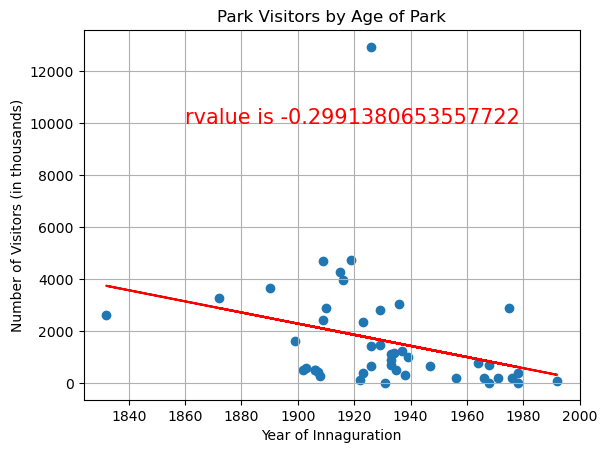

In [36]:
x_values = combined_park_and_history_data_df["Year"].astype('int')
visitors = combined_park_and_history_data_df["Value"].str.replace(",", "").astype('float')
y_values = visitors/1000


plt.scatter(x_values, y_values )

plt.title("Park Visitors by Age of Park")
plt.ylabel("Number of Visitors (in thousands)")
plt.xlabel("Year of Innaguration")
plt.grid(True)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(f"rvalue is {rvalue}",(1860,10000),fontsize=15,color="red")

print(f"slope is {slope}, intercept is {intercept}, rvalue is {rvalue}, pvalue is {pvalue}, stderr is {stderr}")
plt.show